In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
# from google.colab import drive
# drive.mount('/content/drive/')
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import (ExponentialSmoothing,SimpleExpSmoothing,Holt)
from xgboost import XGBRegressor,XGBClassifier
import lightgbm as lgb
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

# from catboost import CatBoostRegressor

In [ ]:
anormaly_train1 = pd.read_csv('anomaly_train.csv')

for i in range(len(anormaly_train1)):
    if anormaly_train1['oven_id'][i] == '1.00E+00':
        anormaly_train1['oven_id'][i] = '1E0'
    elif anormaly_train1['oven_id'][i] == '2.00E+00':
        anormaly_train1['oven_id'][i] = '2E0'

In [ ]:
#建立空的2021/12/27-2023/02/06的各爐及各層的資料
oven,layer,date,anormaly_total_number = [],[],[],[]
for d in pd.date_range('2021/12/27','2023/02/06'):
  # for i in ['1B0','1C0','1D0','1.00E+00','1G0','2B0','2C0','2D0','2.00E+00','2G0']:
  for i in ['1B0','1C0','1D0','1E0','1G0','2B0','2C0','2D0','2E0','2G0']:
    for j in range(1,20):
      oven.append(i)
      layer.append(j)
      date.append(d)
      anormaly_total_number.append(0)

accumulation = np.zeros(407*10*19)
lamp = np.zeros(407*10*19)

full_data = {"oven_id": oven ,'layer_id':layer,'date':date,"lamp_id":lamp,"anomaly_accumulation_hour":accumulation,"anomaly_total_number":anormaly_total_number }
full_data = pd.DataFrame(full_data)

In [ ]:
#建立2021/12/27-2023/02/06有異常的爐和層的資料
# anormaly_train_1 = anormaly_train1[['date','oven_id','layer_id','anomaly_total_number']]
anormaly_train1['date'] = pd.to_datetime(anormaly_train1['date'],format='%Y-%m-%d')

#合併2021/12/27-2023/02/06所有爐和所有層的資料
df = pd.concat([anormaly_train1,full_data])
df.drop_duplicates(subset=['date','oven_id','layer_id'], keep='first', inplace=True)
df = df.reset_index().drop(['index'],axis=1)

###  ETS Decomposition Models(error-trend-seasonality)

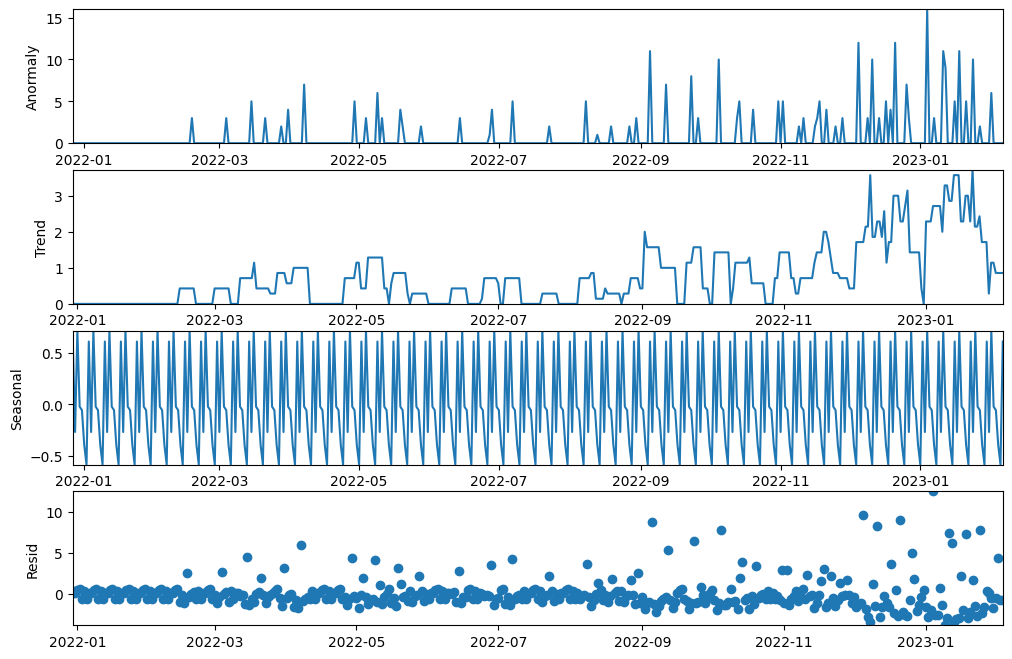

In [ ]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.tsa.api as smt
from statsmodels.tsa.seasonal import seasonal_decompose

oven_df = df[df['oven_id']=='2E0'].sort_values(by='date',ascending=True)
oven2_total_anormal = oven_df.groupby(['date'])['anomaly_total_number'].sum()

arima_data = oven2_total_anormal

result = seasonal_decompose(arima_data)
plt.figure(figsize=(12,8))
plt.subplot(4,1,1)
plt.plot(result.observed, label="Anormaly")
plt.ylabel("Anormaly")
# plt.xticks(df.index[::12], rotation=0) #調整x軸刻度的呈現(每隔12個)
plt.margins(0)

plt.subplot(4,1,2)
plt.plot(result.trend)
plt.ylabel("Trend")
# plt.xticks(df.index[::12], rotation=0)
plt.margins(0)

plt.subplot(4,1,3)
plt.plot(result.seasonal)
plt.ylabel("Seasonal")
# plt.xticks(df.index[::12], rotation=0)
plt.margins(0)

plt.subplot(4,1,4)
plt.scatter( oven2_total_anormal.index,result.resid)
plt.ylabel("Resid")
# plt.xticks(df.index[::12], rotation=0)
plt.margins(0)  #拆成四個subplot以利調整圖片間距、x軸刻度的呈現

In [ ]:
import numpy as np
from scipy.fft import fft

oven_df = df[df['oven_id']=='2D0'].sort_values(by='date',ascending=True)
ts = oven_df.groupby(['date'])['anomaly_total_number'].sum()
ts = ts[:-22]

# 假設資料已經讀入一個名為 'ts' 的時間序列
n = len(ts)
frequency = np.fft.fftfreq(n)
fft_values = fft(ts)
amplitude = np.abs(fft_values)

# 找到最大振幅的頻率成分
max_amplitude_index = np.argmax(amplitude[1:]) + 1
seasonality_period = 1 / frequency[max_amplitude_index]
print('Estimated Seasonality Period:', seasonality_period)

Estimated Seasonality Period: 385.0


## ACF、PACF

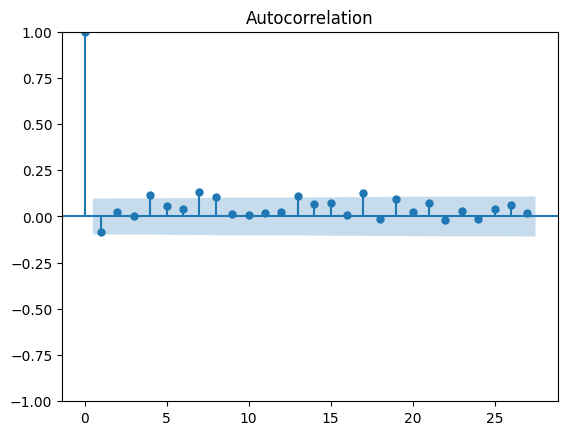

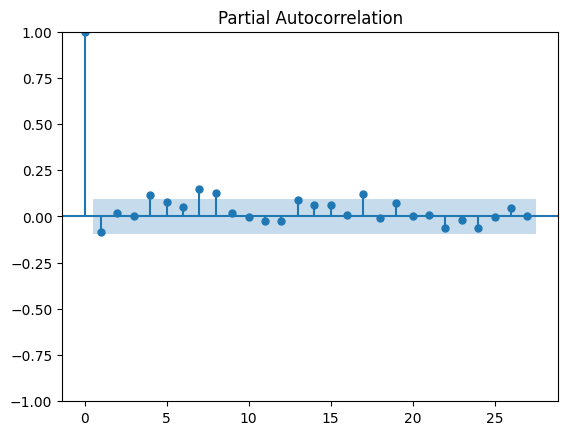

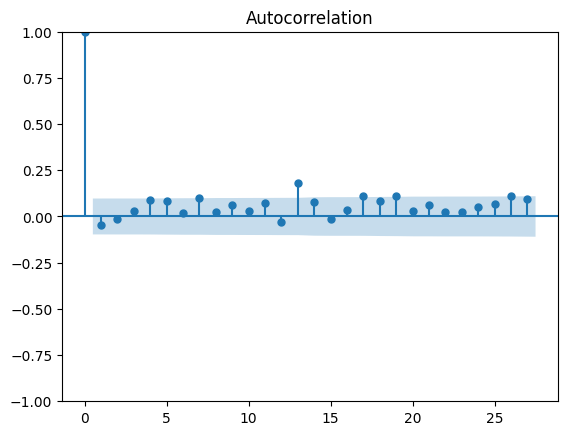

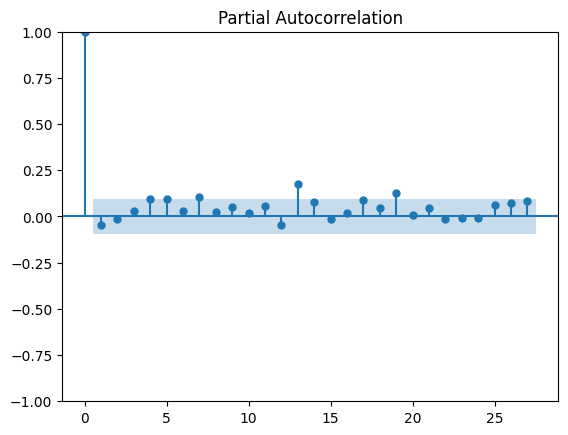

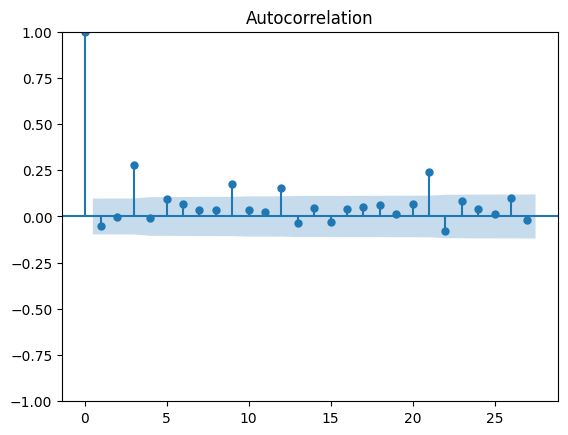

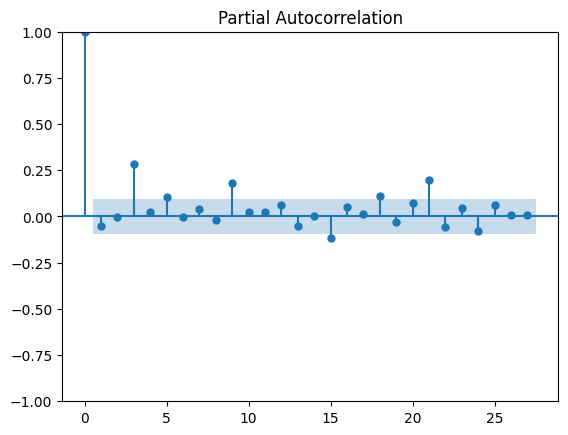

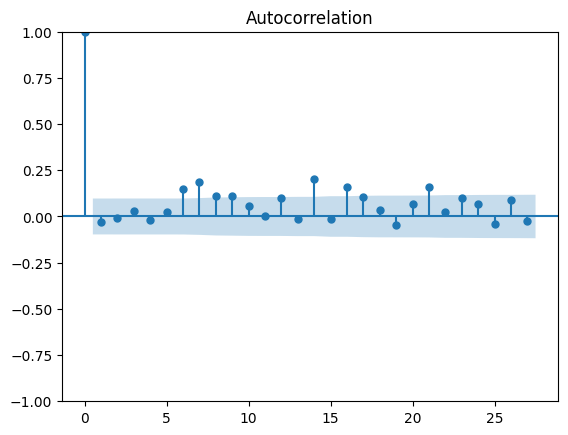

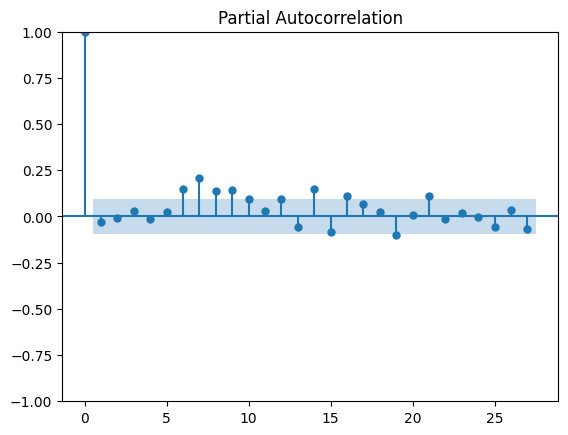

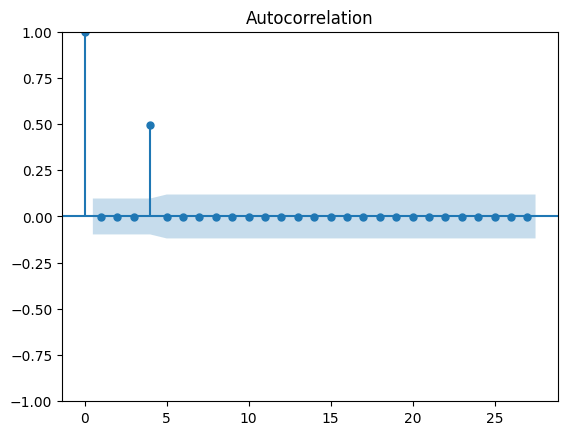

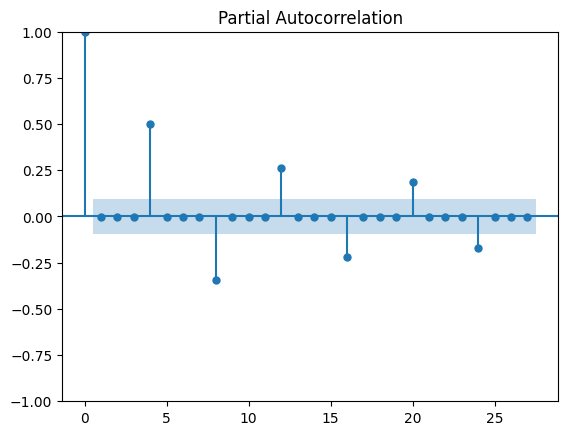

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
oven_2 = ['2B0','2C0','2D0','2E0','2G0']
# oven_2 = ['1B0','1C0','1D0','1E0','1G0','2B0','2C0','2D0','2E0','2G0']
ma_preds ,holt_preds ,period_preds,sarima_preds ,actual= [],[],[],[],[]

for i in oven_2:
    oven_df = df[df['oven_id']==i].sort_values(by='date',ascending=True)
    oven2_total_anormal = oven_df.groupby(['date'])['anomaly_total_number'].sum()
    plot_acf(oven2_total_anormal)
    plot_pacf(oven2_total_anormal)

### 平穩性檢驗：Dickey Fuller test

In [ ]:
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print("Results of Dickey-Fuller Test\n================================================")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(dftest[0:4], index = [
        "Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key, value in dftest[4].items():
        dfoutput["Criterical Value (%s)"%key] = value
    print(dfoutput)
    print("================================================")

    if dfoutput[0] < dfoutput[4]:
        print("The data is stationary. (Criterical Value 1%)")
    elif dfoutput[0] < dfoutput[5]:
        print("The data is stationary. (Criterical Value 5%)")
    elif dfoutput[0] < dfoutput[6]:
        print("The data is stationary. (Criterical Value 10%)")
    else:
        print("The data is non-stationary, so do differencing!")

adf_test(arima_data)

Results of Dickey-Fuller Test
Test Statistic                  -2.296954
p-value                          0.172952
#Lags Used                      16.000000
Number of Observations Used    390.000000
Criterical Value (1%)           -3.447229
Criterical Value (5%)           -2.868980
Criterical Value (10%)          -2.570733
dtype: float64
The data is non-stationary, so do differencing!


In [ ]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model = pm.auto_arima( arima_data.values, start_p=1, start_q=1,
                      information_criterion='aic',
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=10, max_q=10, # maximum p and q
                      m=7,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,    # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,1)[7] intercept   : AIC=1779.740, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=1786.957, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=1773.477, Time=0.07 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=1777.844, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=1830.245, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=1788.597, Time=0.03 sec
 ARIMA(1,0,0)(2,0,0)[7] intercept   : AIC=1763.989, Time=0.13 sec
 ARIMA(1,0,0)(2,0,1)[7] intercept   : AIC=1756.323, Time=0.29 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=1754.381, Time=0.17 sec
 ARIMA(1,0,0)(0,0,1)[7] intercept   : AIC=1777.966, Time=0.07 sec
 ARIMA(1,0,0)(1,0,2)[7] intercept   : AIC=1756.324, Time=0.29 sec
 ARIMA(1,0,0)(0,0,2)[7] intercept   : AIC=1771.022, Time=0.13 sec
 ARIMA(1,0,0)(2,0,2)[7] intercept   : AIC=1758.242, Time=0.43 sec
 ARIMA(0,0,0)(1,0,1)[7] intercept   : AIC=1754.489, Time=0.14 sec
 ARIMA(2,0,0)(1,0,1)[7] intercept

In [ ]:
def rmse(y,yhat):
  return np.sqrt(mean_squared_error(y,yhat))

def Moving_Average( y , window_size , predict_period):
  train_y_df = pd.DataFrame(y)
  roll = train_y_df.rolling(window_size).mean().values
  ma = list( roll.reshape( len(y) ) )
  for i in range(predict_period):
    ma.append(np.mean(ma[-window_size:]))
  ma_pred = ma[-predict_period:]
  return ma_pred

def best_window_size( valid_y ,training_y, predict_period = 22):
  best_rmse , best_window_size_1 = 100,100
  best_diff , best_window_size_2 = 100,100

  for window in range(2,22):
    valid_pred = Moving_Average( y = training_y , window_size = window , predict_period = predict_period)
    RMSE = rmse( valid_y , valid_pred )
    diff = abs( np.sum(valid_y) - np.ceil(np.sum(valid_pred) ))

    if RMSE < best_rmse :
      best_rmse = RMSE
      best_window_size_1 = window
    if diff < best_diff :
      best_diff = diff
      best_window_size_2 = window

  # print('best rmse=',best_rmse,'best window size=',best_window_size)
  print("Moving Average |",'best diff=',best_diff,'best window size=',best_window_size_2)
  return best_window_size_2

def period_split(data,period):
    '''
    period : 以幾天作為一期
    data: 訓練資料
    '''
    period_data = []
    for j in range( int(len(data) /period) ,0,-1):
        period_data.append( np.sum( data[  len(data) -period*j :  len(data) -period*(j-1) ]) )
    prediction_period = int(22/period)+1
    return prediction_period,period_data

def best_period_MA(train_y, valid_y, period_split_day,max_window):

  best_period,best_diff = 100,100
  best_window_diff , best_window_size_2 = 100,100
  for i in range(2,period_split_day):
    prediction_period, period_train_data = period_split(train_y,i)
    _ , period_valid_data = period_split(valid_y,i)

    for window in range(2,max_window):
      valid_pred = Moving_Average( y = period_train_data , window_size = window , predict_period = prediction_period)
      window_diff = abs( np.sum(period_valid_data) - np.ceil(np.sum(valid_pred) ))

      if window_diff < best_window_diff :
        best_window_diff = window_diff
        best_window_size_2 = window

    valid_pred = Moving_Average( period_train_data , window_size = best_window_size_2 , predict_period = prediction_period )
    diff = abs( np.sum(period_valid_data) - np.ceil(np.sum(valid_pred) ))
    if diff < best_diff :
      best_diff = diff
      best_period = i

  print("Period MA |",'best diff =',best_diff,'best period =',best_period,"best window size =",best_window_size_2)
  return best_period,best_window_size_2

def period_predict(training_data,period_split_day,window_size):
  prediction_period, period_train_data = period_split(training_data,period_split_day)
  prediction = Moving_Average( y = period_train_data , window_size = window_size , predict_period = prediction_period)
  return prediction

def sarima_model(data, Seasonality):
  model = pm.auto_arima( data, start_p=1, start_q=1,
                        information_criterion='aic',
                        test='adf',       # use adftest to find optimal 'd'
                        max_p=10, max_q=10, # maximum p and q
                        m=14,              # frequency of series
                        d=None,           # let model determine 'd'
                        seasonal= Seasonality,    # No Seasonality
                        start_P=0,
                        D=1,
                        trace=False,
                        error_action='ignore',
                        suppress_warnings=True,
                        stepwise=True)
  pred = model.predict(n_periods=22, return_conf_int=False)
  return pred



## 預測

============================= oven 2B0 =============================
Moving Average | best diff= 1.0 best window size= 5
Period MA | best diff = 0.0 best period = 2 best window size = 3
Actual number : 53 | Holt : 54.0 | Holt-Winters : 55.0 | MA : 65.0 | Period MA : 53.0 | ARIMA : 52.0 | SARIMA : 51.0
============================= oven 2C0 =============================
Moving Average | best diff= 7.0 best window size= 21
Period MA | best diff = 0.0 best period = 5 best window size = 12
Actual number : 51 | Holt : 49.0 | Holt-Winters : 50.0 | MA : 53.0 | Period MA : 62.0 | ARIMA : 45.0 | SARIMA : 59.0
============================= oven 2D0 =============================
Moving Average | best diff= 4.0 best window size= 4
Period MA | best diff = 0.0 best period = 10 best window size = 13
Actual number : 50 | Holt : 49.0 | Holt-Winters : 51.0 | MA : 47.0 | Period MA : 51.0 | ARIMA : 40.0 | SARIMA : 57.0
============================= oven 2E0 =============================
Moving Average | b

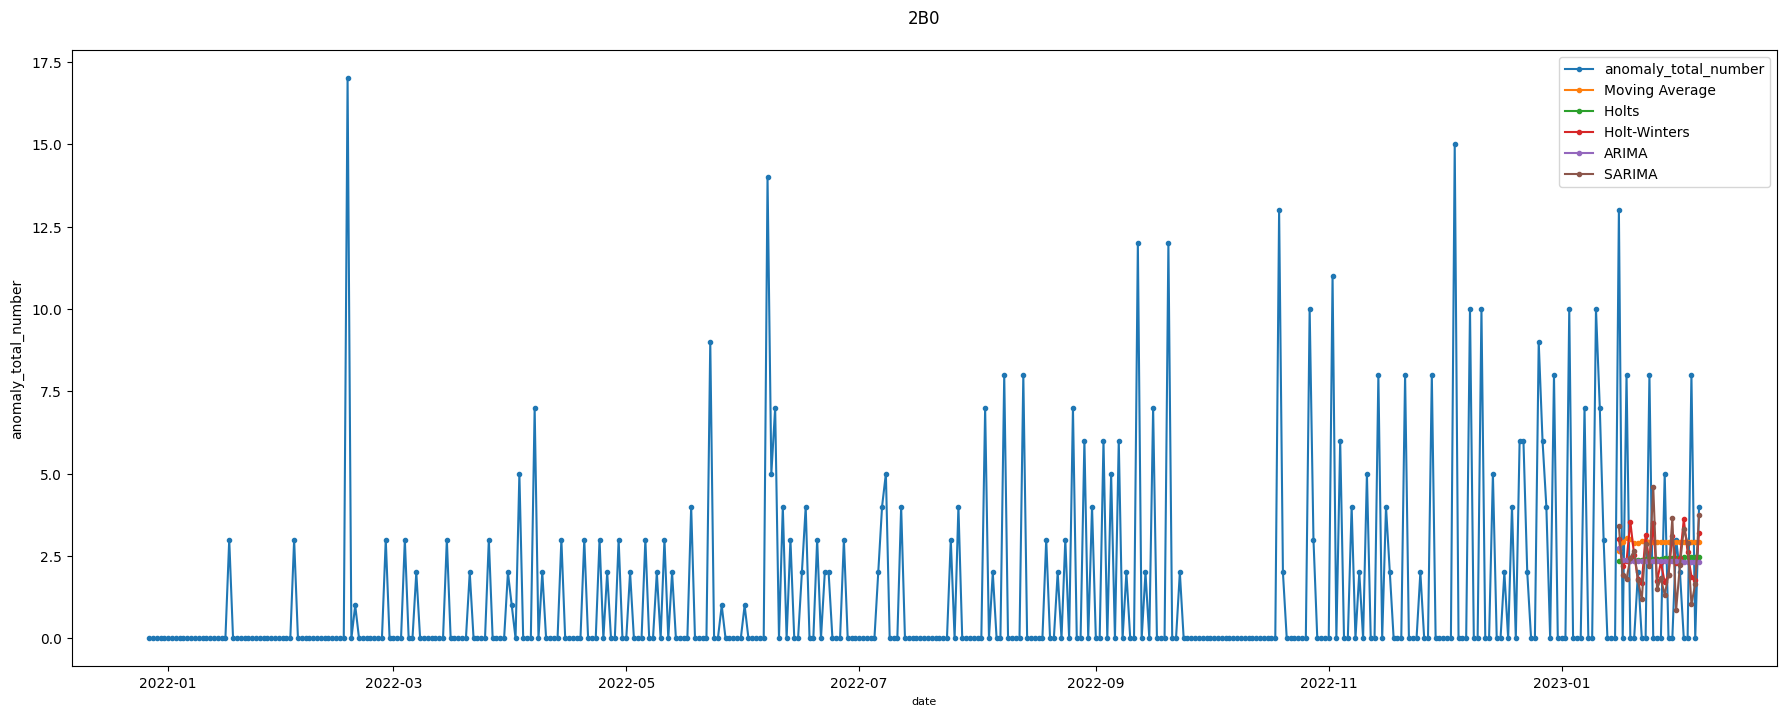

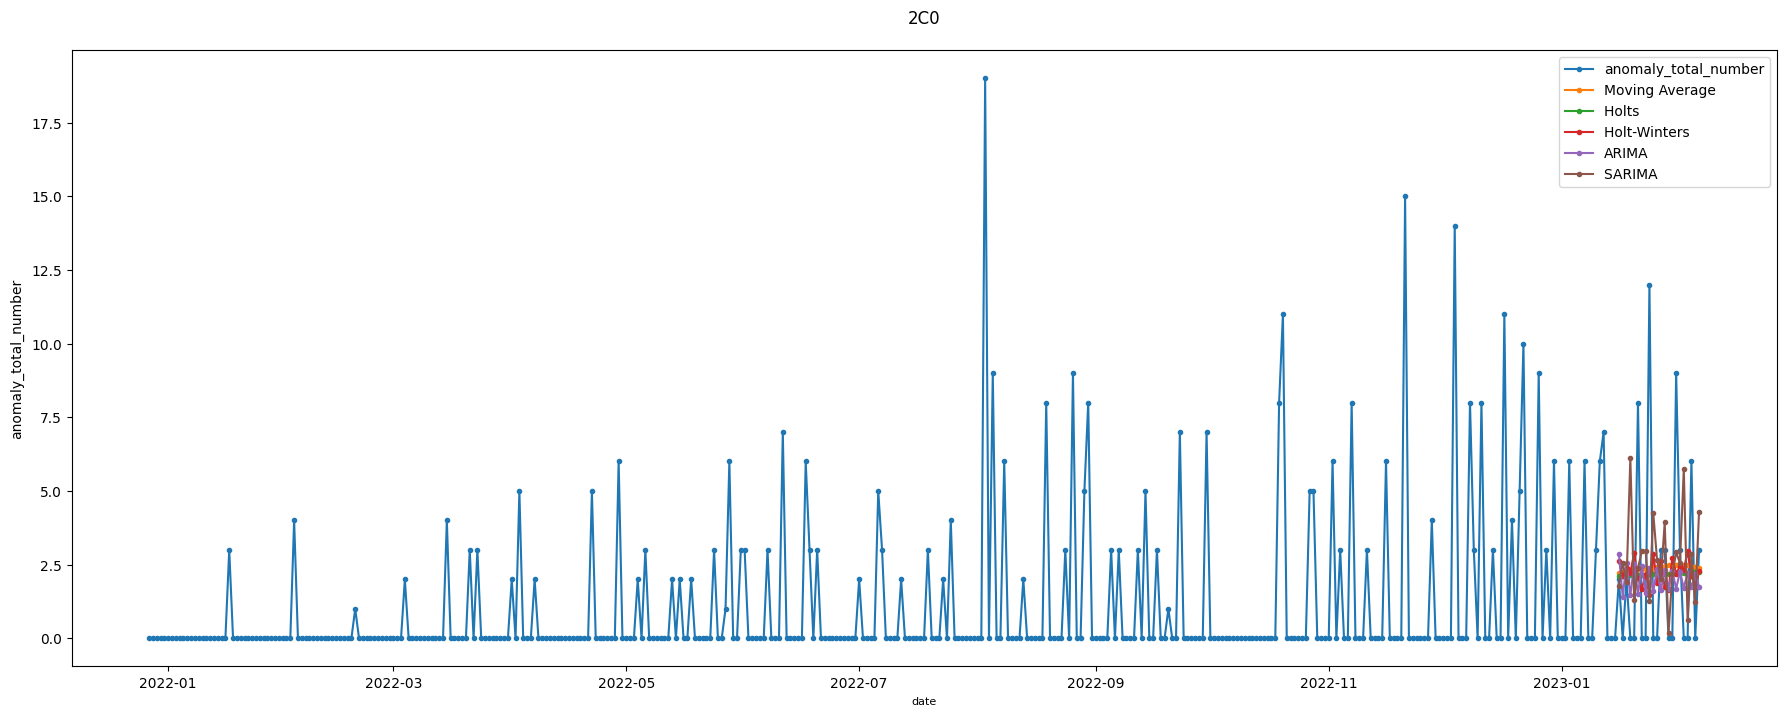

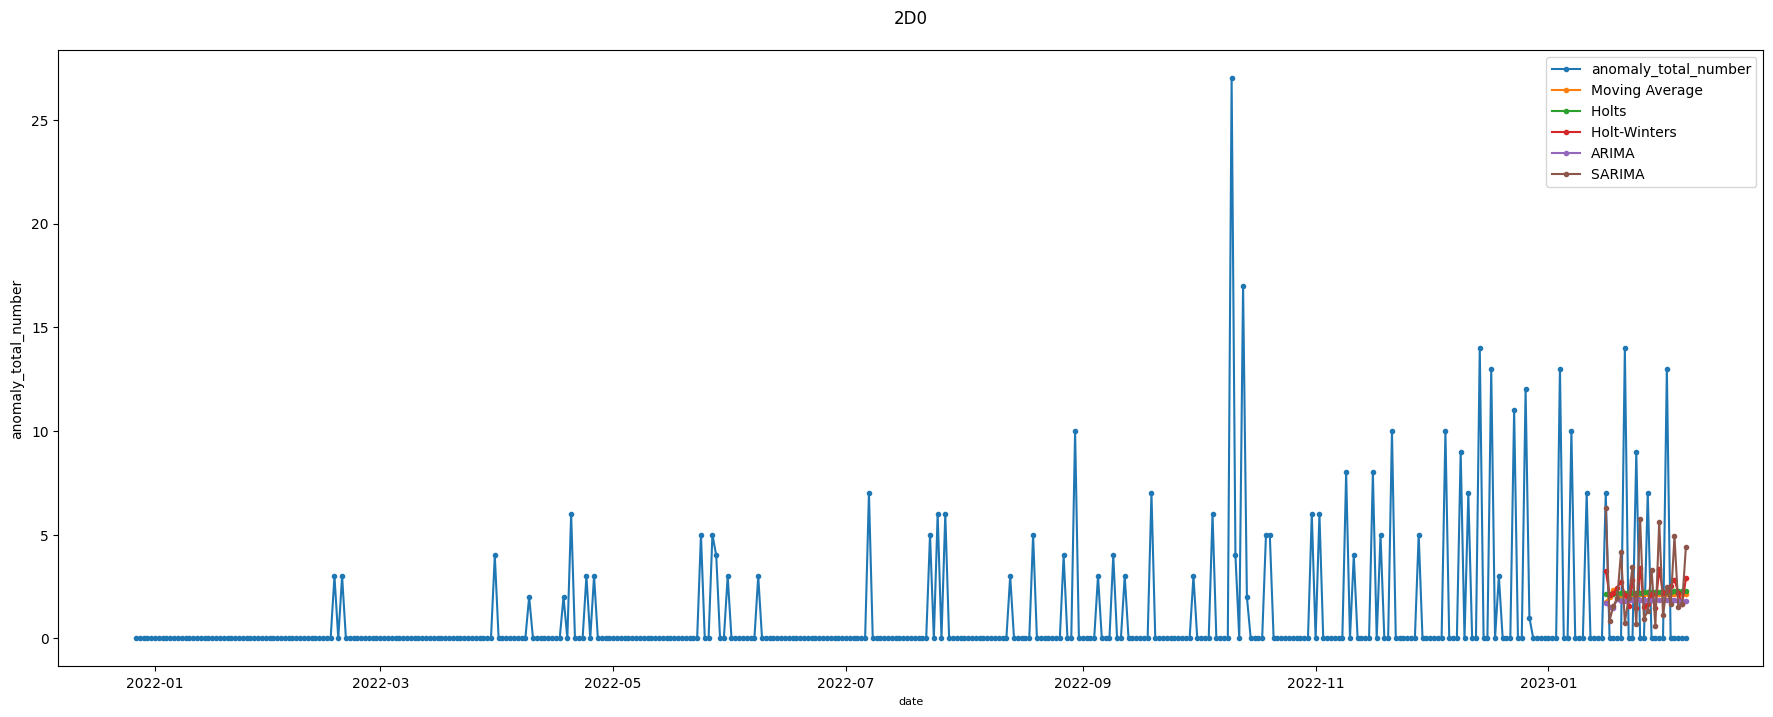

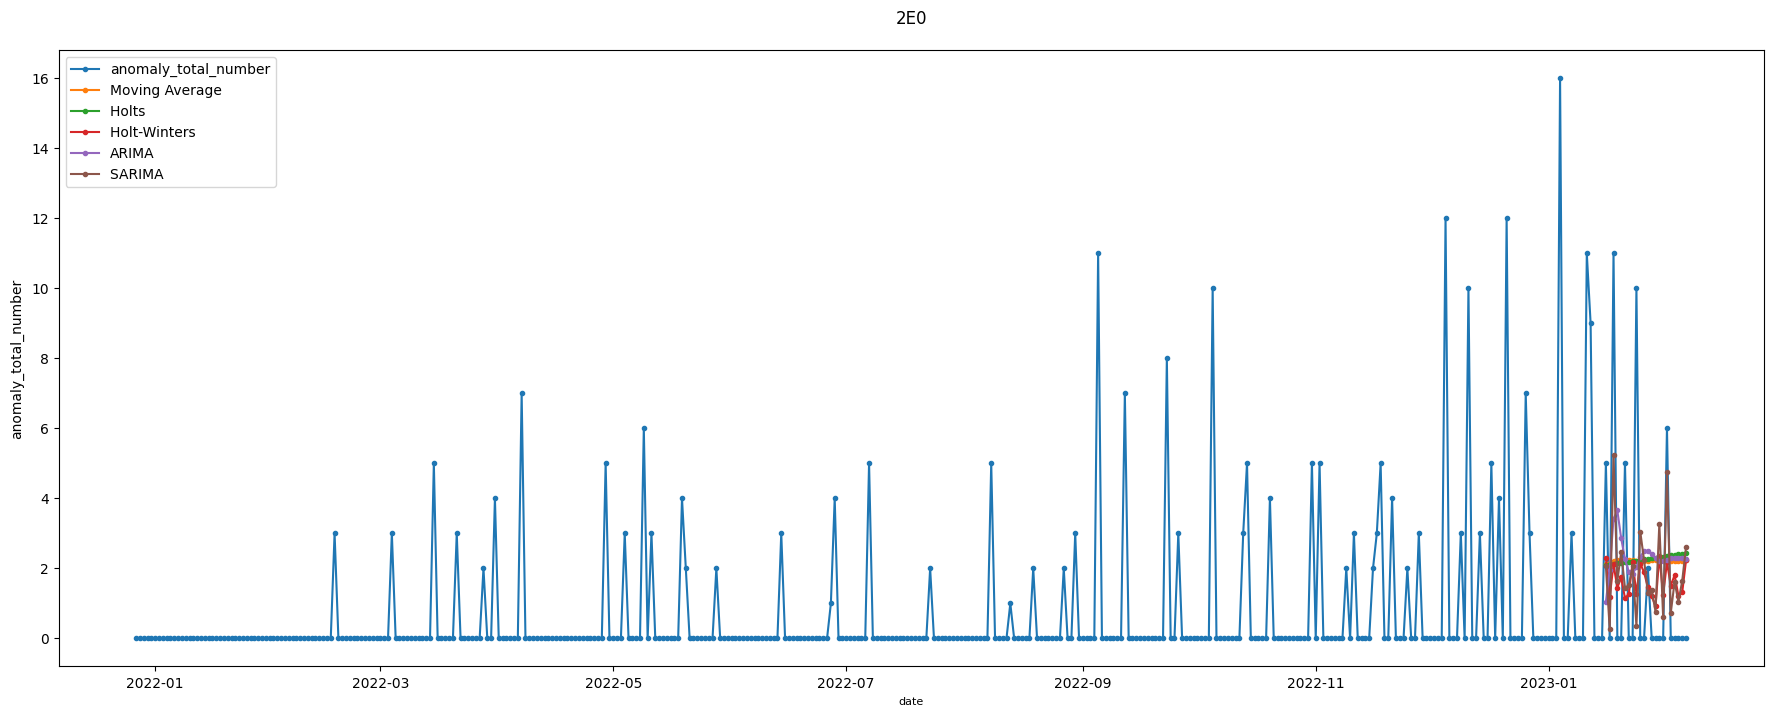

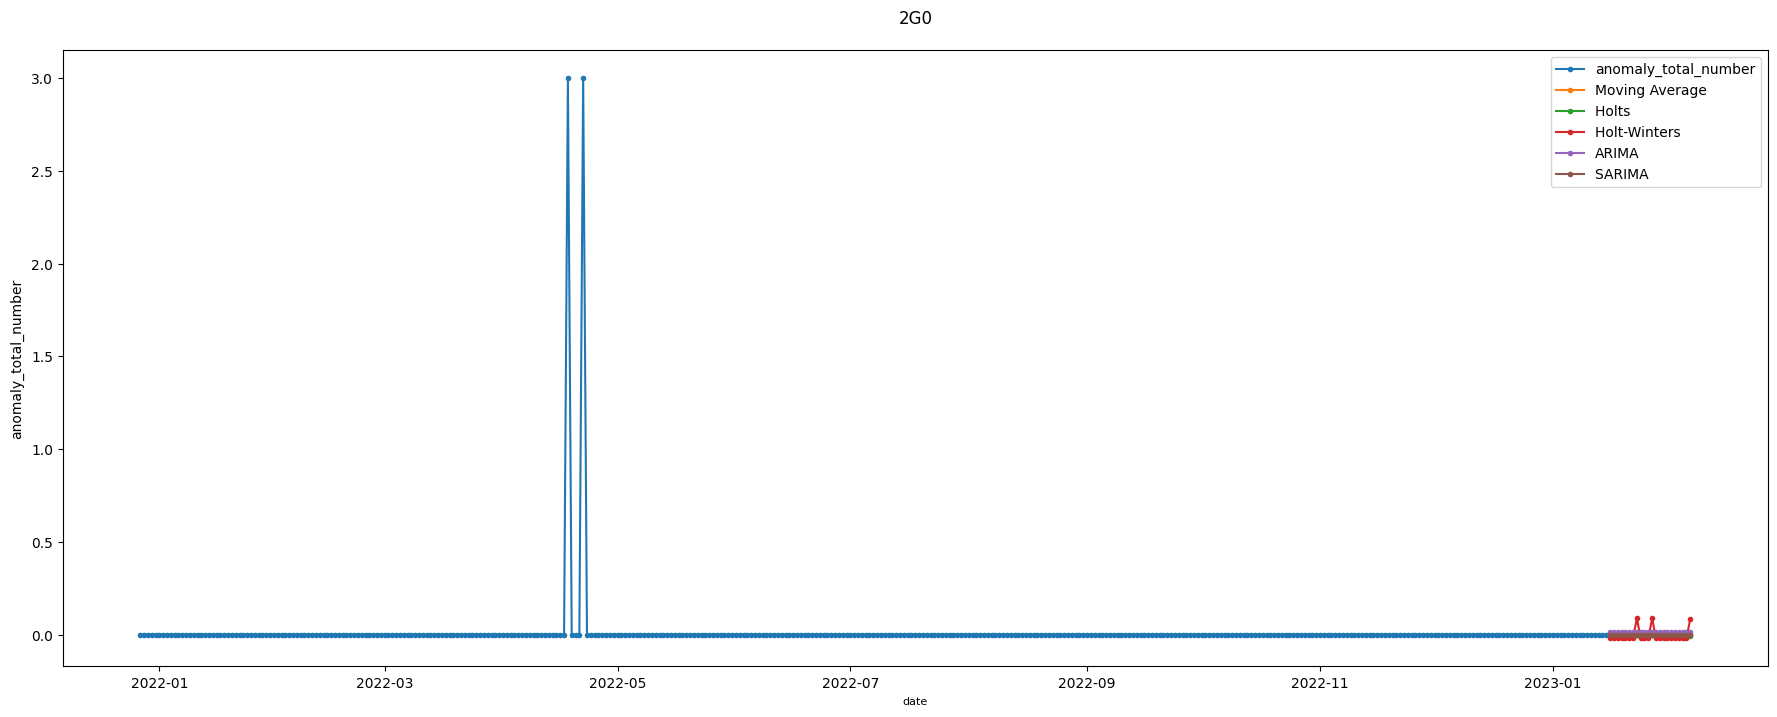

In [ ]:
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.holtwinters import Holt

oven_2 = ['2B0','2C0','2D0','2E0','2G0']
# oven_2 = ['1B0','1C0','1D0','1E0','1G0','2B0','2C0','2D0','2E0','2G0']
ma_preds ,holt_preds ,holt_winter_preds,period_preds,sarima_preds,arima_preds ,actual= [],[],[],[],[],[],[]

for i in oven_2:
    print("============================= oven "+i+" =============================")
    oven_df = df[df['oven_id']==i].sort_values(by='date',ascending=True)
    oven2_total_anormal = oven_df.groupby(['date'])['anomaly_total_number'].sum()
    x = oven2_total_anormal.index
    y =  oven2_total_anormal.values
    train_y = oven2_total_anormal.values[:-44]
    valid_y = oven2_total_anormal.values[-44:-22]
    test_y = oven2_total_anormal.values[-22:]

    test_x = oven2_total_anormal.index[-22:]
    actual.append(np.sum(test_y))

    # Moving Average
    best_window = best_window_size( valid_y ,train_y)
    MA_pred = Moving_Average( train_y , window_size = best_window , predict_period=22)
    ma_preds.append(np.ceil(np.sum(MA_pred)))

    # Holt (二指数平滑法)
    holt_pred = ExponentialSmoothing( y[:-22] ,  trend='add' ).fit().forecast(22)
    holt_preds.append(np.ceil(np.sum(holt_pred)))

    # holt's winter (三指数平滑法)
    holt_winter_pred = ExponentialSmoothing( y[:-22] , seasonal_periods=14, trend='add', seasonal='add' ).fit().forecast(22)
    holt_winter_preds.append(np.ceil(np.sum(holt_winter_pred)))

    # 以多天為一期的Moving Average
    period , window = best_period_MA(train_y, valid_y, period_split_day= 22,max_window = 14)
    period_pred = period_predict(training_data = y[:-22] , period_split_day = period, window_size = period)
    period_preds.append(np.ceil(np.sum(period_pred)))

    # ARIMA
    arima_pred = sarima_model( y[:-22] ,Seasonality = False )
    arima_preds.append(np.ceil(np.sum(arima_pred)))

    # SARIMA
    sarima_pred = sarima_model( y[:-22] ,Seasonality = True)
    sarima_preds.append(np.ceil(np.sum(sarima_pred)))


    print('Actual number :',actual[-1] ,'| Holt :',holt_preds[-1],'| Holt-Winters :',holt_winter_preds[-1],
          '| MA :',ma_preds[-1] ,'| Period MA :', period_preds[-1],
          "| ARIMA :",arima_preds[-1],"| SARIMA :",sarima_preds[-1])

    plt.figure(figsize = (22,8), dpi = 100, linewidth = 2)
    plt.plot( x, y , 'p-', label= 'anomaly_total_number',marker='.')
    plt.plot( test_x , MA_pred , 'p-', label= 'Moving Average',marker='.')
    plt.plot( test_x , holt_pred , 'p-', label= 'Holts ',marker='.')
    plt.plot( test_x , holt_winter_pred , 'p-', label= 'Holt-Winters ',marker='.')
    plt.plot( test_x , arima_pred , 'p-', label= 'ARIMA',marker='.')
    plt.plot( test_x , sarima_pred , 'p-', label= 'SARIMA ',marker='.')
    plt.title(i , x = 0.5, y = 1.03)
    plt.yticks(fontsize = 10)
    plt.xlabel("date", fontsize = 8, labelpad = 5)
    plt.ylabel("anomaly_total_number", fontsize = 10, labelpad = 5)
    plt.legend(loc = "best", fontsize = 10)
    plt.plot()

print("="*110)
print('MA RMSE=',rmse(ma_preds,actual))
print('holts RMSE=',rmse(holt_preds,actual))
print('holt-winter RMSE=',rmse(holt_winter_preds,actual))
print('Period MA RMSE=',rmse(period_preds,actual))
print('ARIMA RMSE=',rmse(arima_preds,actual))
print('SARIMA RMSE=',rmse(sarima_preds,actual))

## Test 資料預測

Moving Average | best diff= 1.0 best window size= 5
Period MA | best diff = 0.0 best period = 2 best window size = 3
Moving Average | best diff= 7.0 best window size= 21
Period MA | best diff = 0.0 best period = 5 best window size = 12
Moving Average | best diff= 4.0 best window size= 4
Period MA | best diff = 0.0 best period = 10 best window size = 13
Moving Average | best diff= 0.0 best window size= 10
Period MA | best diff = 0.0 best period = 3 best window size = 6
Moving Average | best diff= 0.0 best window size= 2
Period MA | best diff = 0.0 best period = 2 best window size = 2


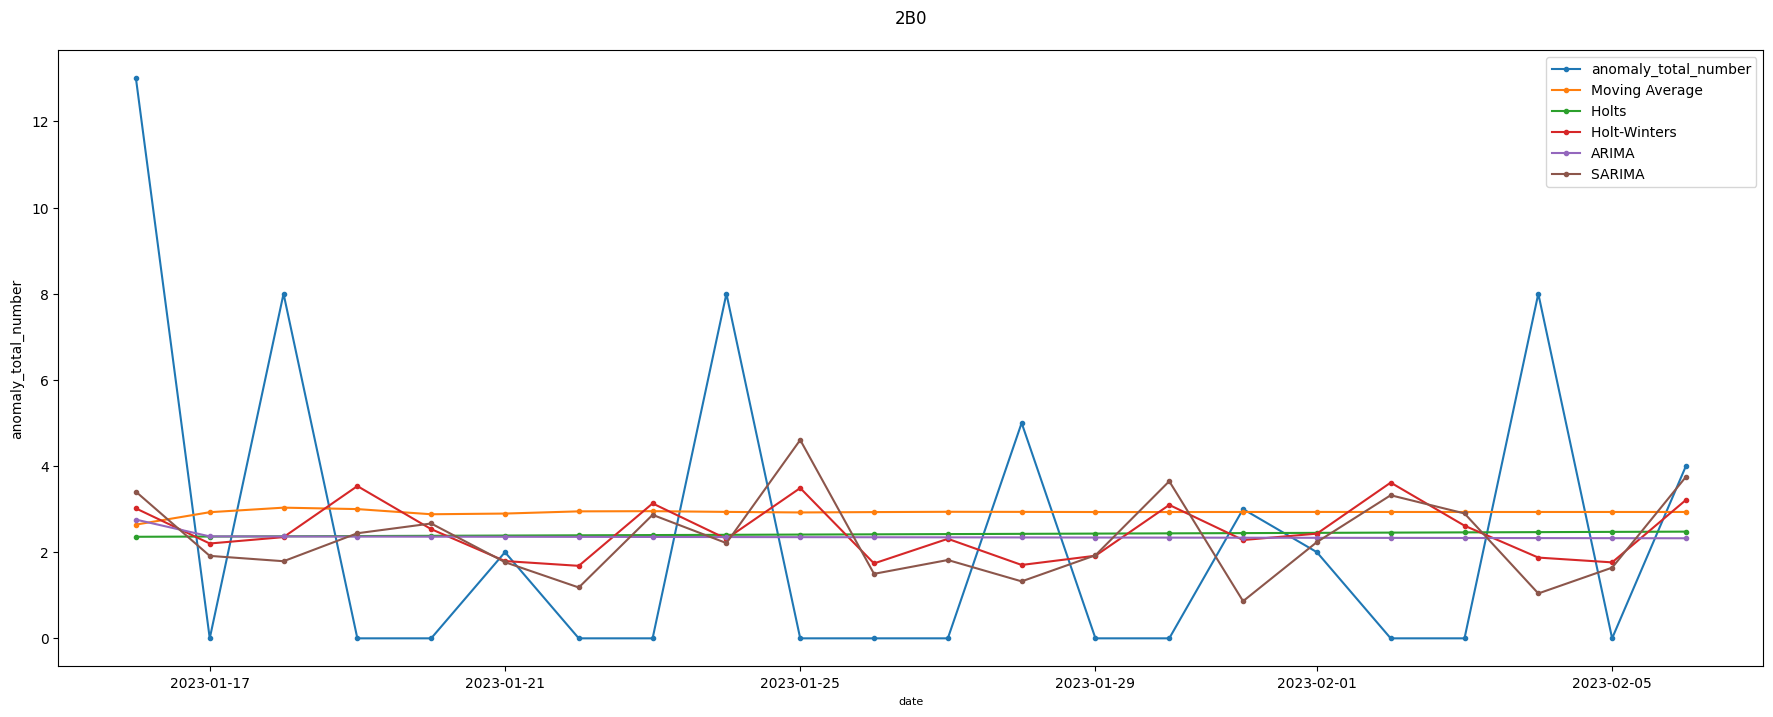

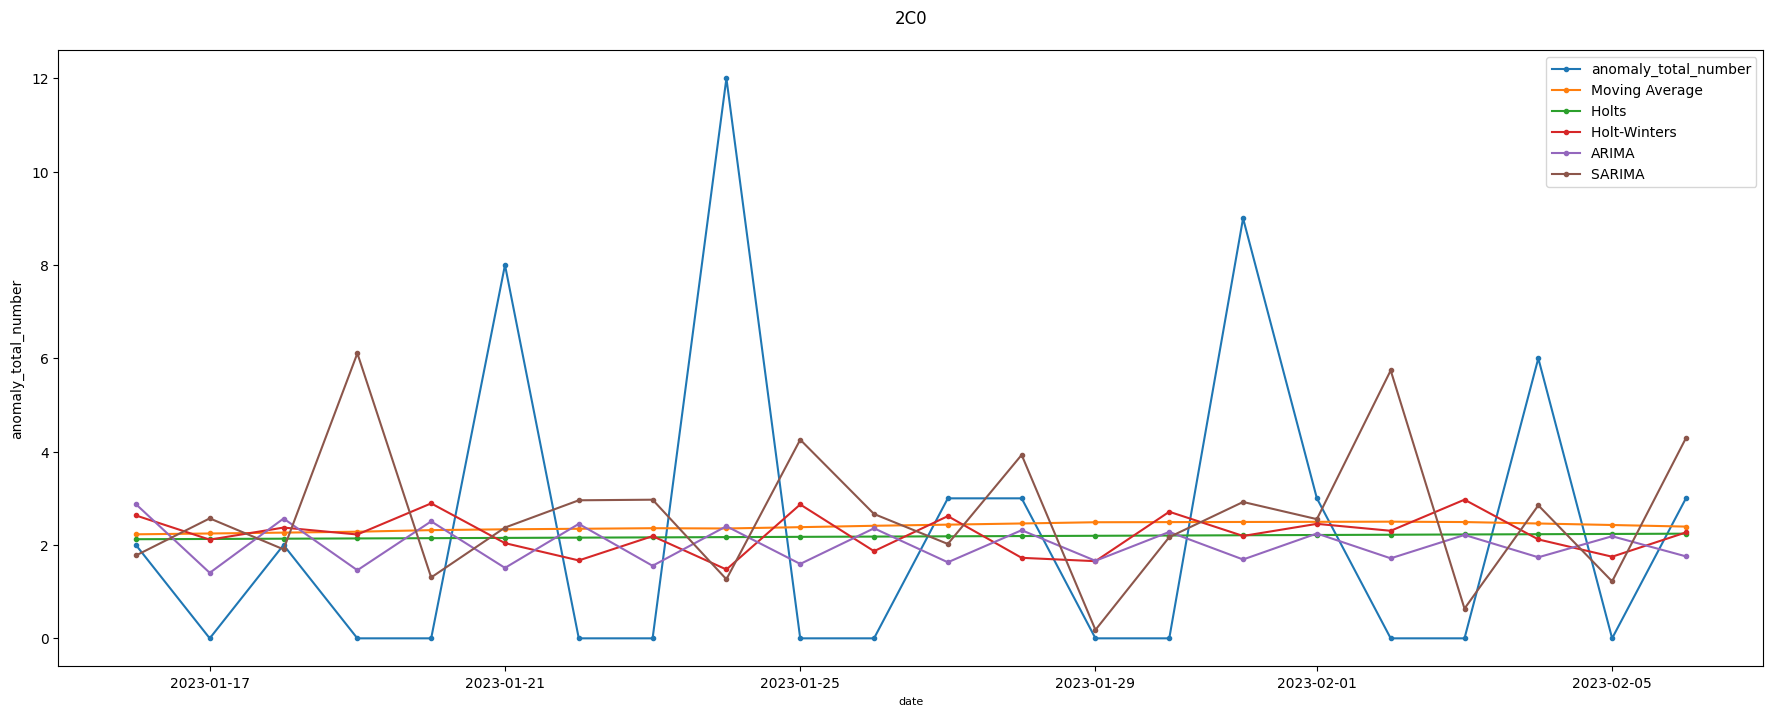

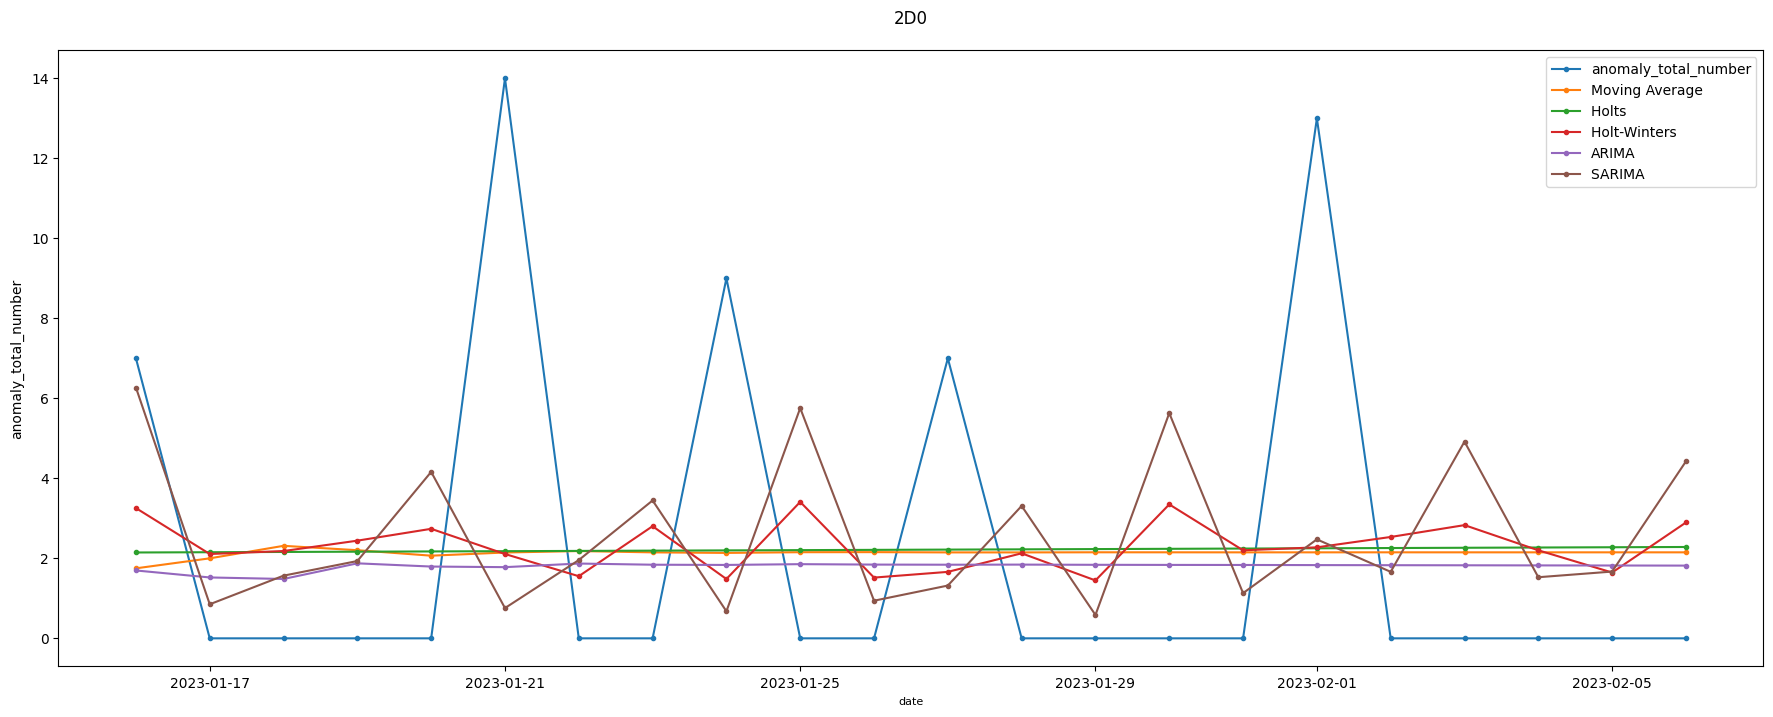

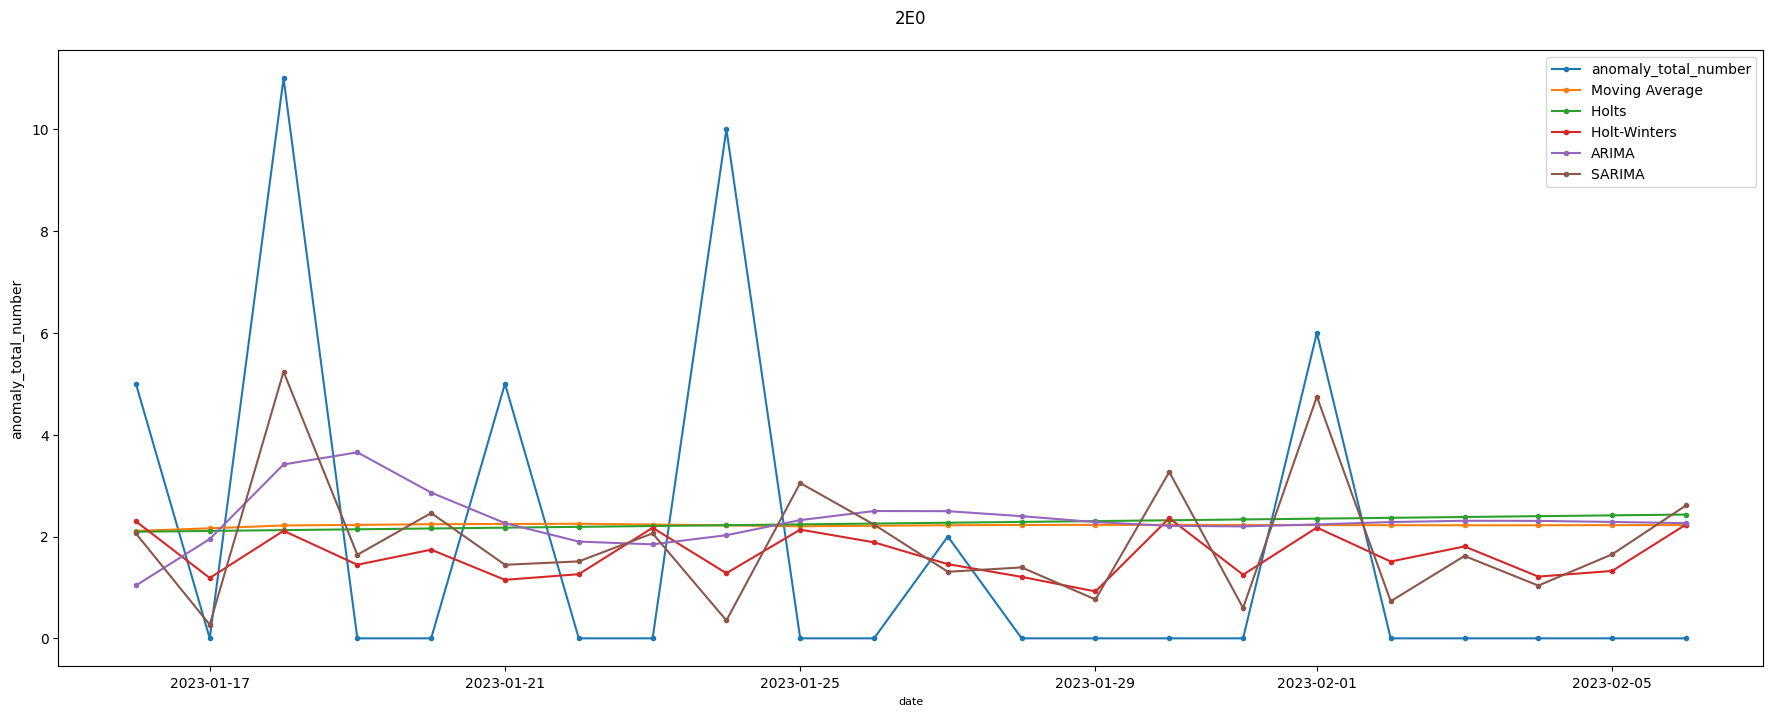

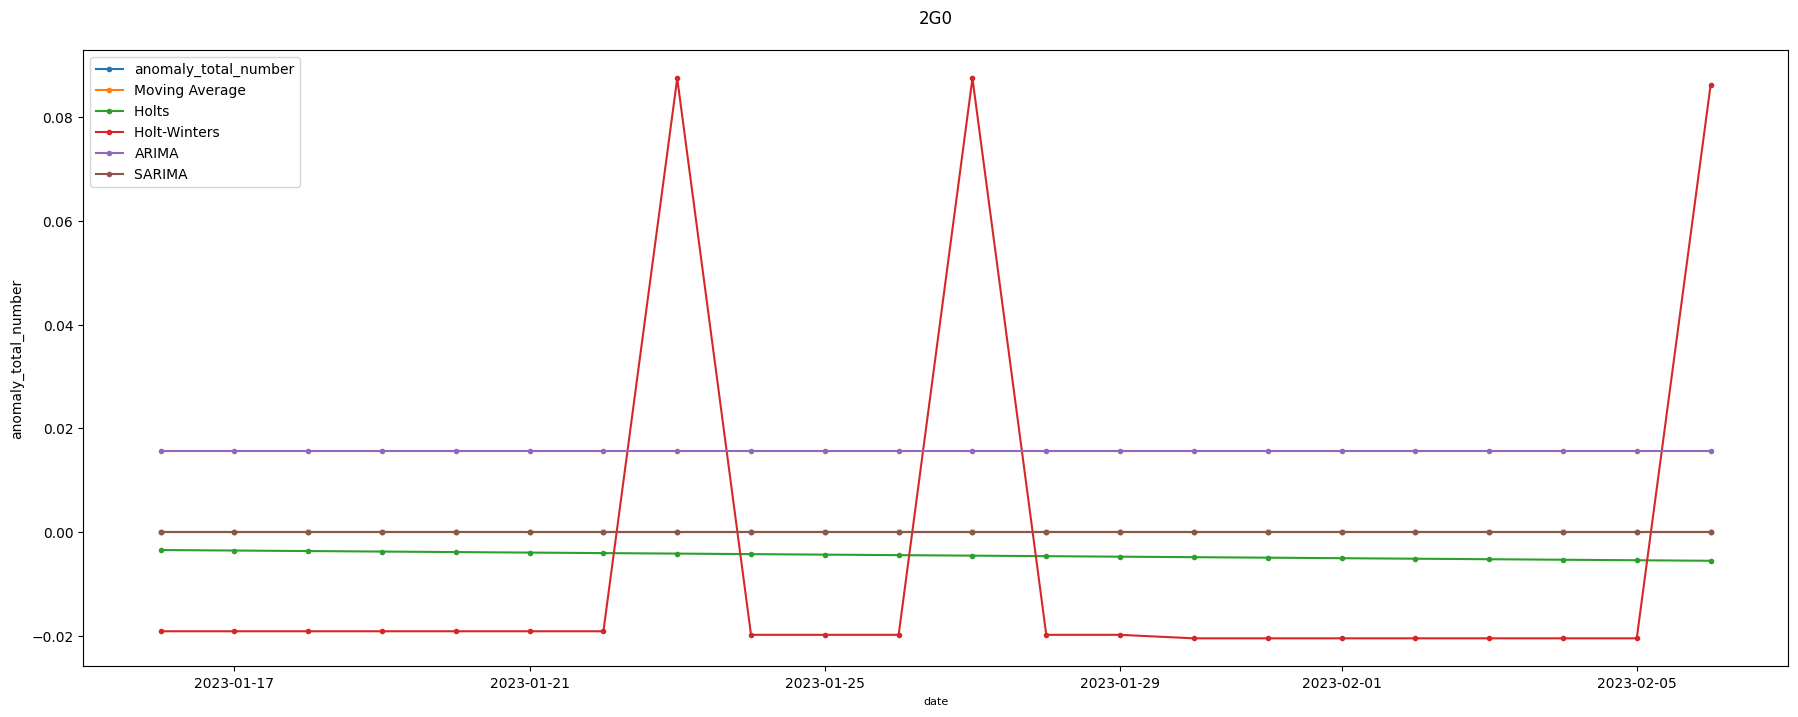

In [ ]:
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.holtwinters import Holt

oven_2 = ['2B0','2C0','2D0','2E0','2G0']
# oven_2 = ['1B0','1C0','1D0','1E0','1G0','2B0','2C0','2D0','2E0','2G0']
ma_preds ,holt_preds ,holt_winter_preds,period_preds,sarima_preds,arima_preds ,actual= [],[],[],[],[],[],[]

for i in oven_2:
    # print("============================= oven "+i+" =============================")
    oven_df = df[df['oven_id']==i].sort_values(by='date',ascending=True)
    oven2_total_anormal = oven_df.groupby(['date'])['anomaly_total_number'].sum()
    x = oven2_total_anormal.index
    y =  oven2_total_anormal.values
    train_y = oven2_total_anormal.values[:-44]
    valid_y = oven2_total_anormal.values[-44:-22]
    test_y = oven2_total_anormal.values[-22:]

    test_x = oven2_total_anormal.index[-22:]
    actual.append(np.sum(test_y))

    # Moving Average
    best_window = best_window_size( valid_y ,train_y)
    MA_pred = Moving_Average( train_y , window_size = best_window , predict_period=22)
    ma_preds.append(np.ceil(np.sum(MA_pred)))

    # Holt (二指数平滑法)
    holt_pred = ExponentialSmoothing( y[:-22] ,  trend='add' ).fit().forecast(22)
    holt_preds.append(np.ceil(np.sum(holt_pred)))

    # holt's winter (三指数平滑法)
    holt_winter_pred = ExponentialSmoothing( y[:-22] , seasonal_periods=14, trend='add', seasonal='add' ).fit().forecast(22)
    holt_winter_preds.append(np.ceil(np.sum(holt_winter_pred)))

    # 以多天為一期的Moving Average
    period , window = best_period_MA(train_y, valid_y, period_split_day= 22,max_window = 14)
    period_pred = period_predict(training_data = y[:-22] , period_split_day = period, window_size = period)
    period_preds.append(np.ceil(np.sum(period_pred)))

    # ARIMA
    arima_pred = sarima_model( y[:-22] ,Seasonality = False )
    arima_preds.append(np.ceil(np.sum(arima_pred)))

    # SARIMA
    sarima_pred = sarima_model( y[:-22] ,Seasonality = True)
    sarima_preds.append(np.ceil(np.sum(sarima_pred)))

    # print('Actual number :',actual[-1] ,'| Holt :',holt_preds[-1],'| Holt-Winters :',holt_winter_preds[-1],
    #       '| MA :',ma_preds[-1] ,'| Period MA :', period_preds[-1],
    #       "| ARIMA :",arima_preds[-1],"| SARIMA :",sarima_preds[-1])

    plt.figure(figsize = (22,8), dpi = 100, linewidth = 2)
    plt.plot( test_x, y[-22:] , 'p-', label= 'anomaly_total_number',marker='.')
    plt.plot( test_x , MA_pred , 'p-', label= 'Moving Average',marker='.')
    plt.plot( test_x , holt_pred , 'p-', label= 'Holts ',marker='.')
    plt.plot( test_x , holt_winter_pred , 'p-', label= 'Holt-Winters ',marker='.')
    plt.plot( test_x , arima_pred , 'p-', label= 'ARIMA',marker='.')
    plt.plot( test_x , sarima_pred , 'p-', label= 'SARIMA ',marker='.')
    plt.title(i , x = 0.5, y = 1.03)
    plt.yticks(fontsize = 10)
    plt.xlabel("date", fontsize = 8, labelpad = 5)
    plt.ylabel("anomaly_total_number", fontsize = 10, labelpad = 5)
    plt.legend(loc = "best", fontsize = 10)
    plt.plot()

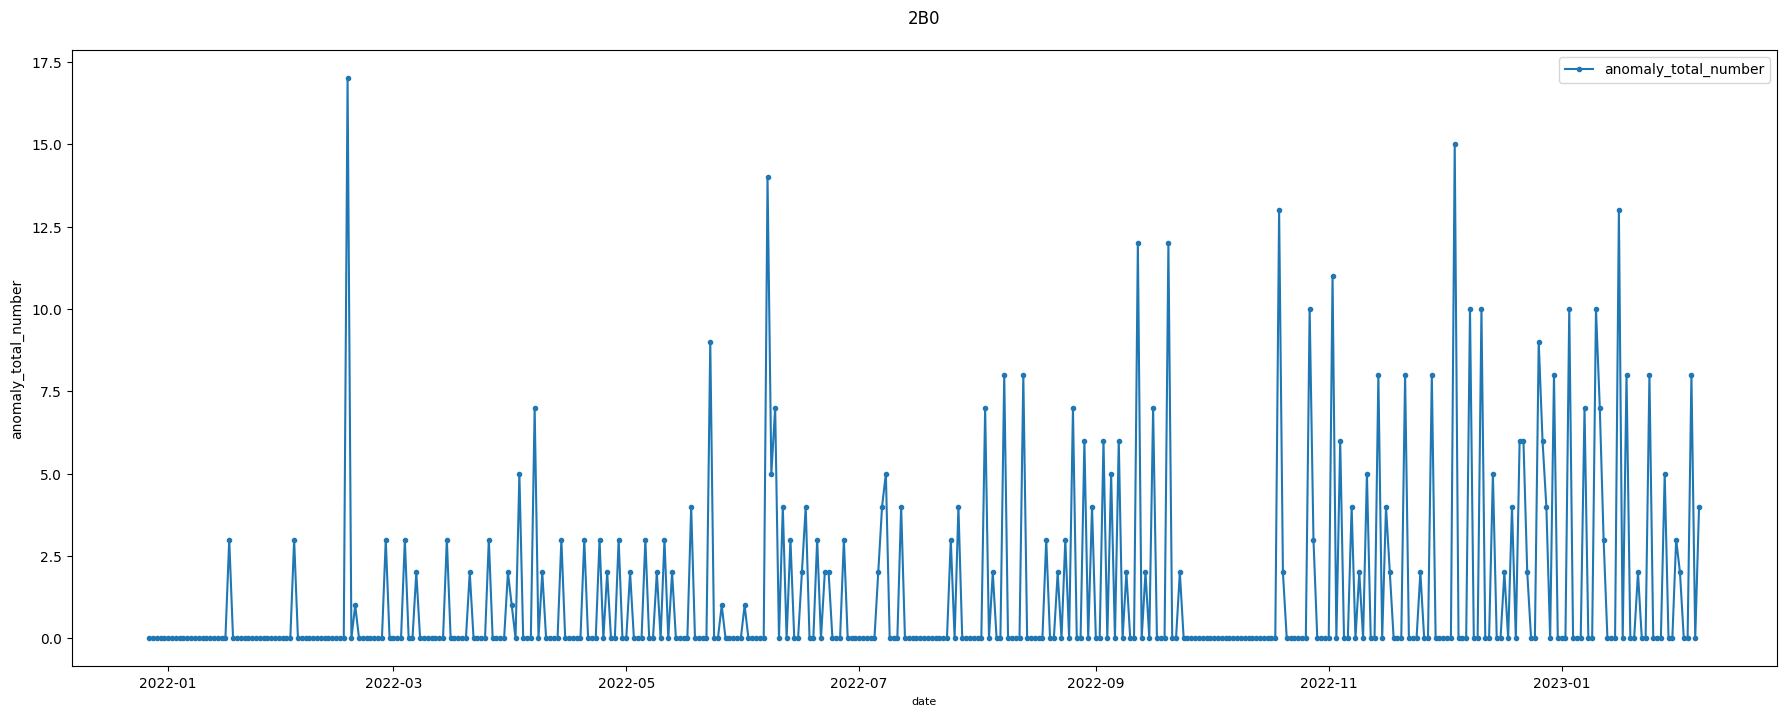

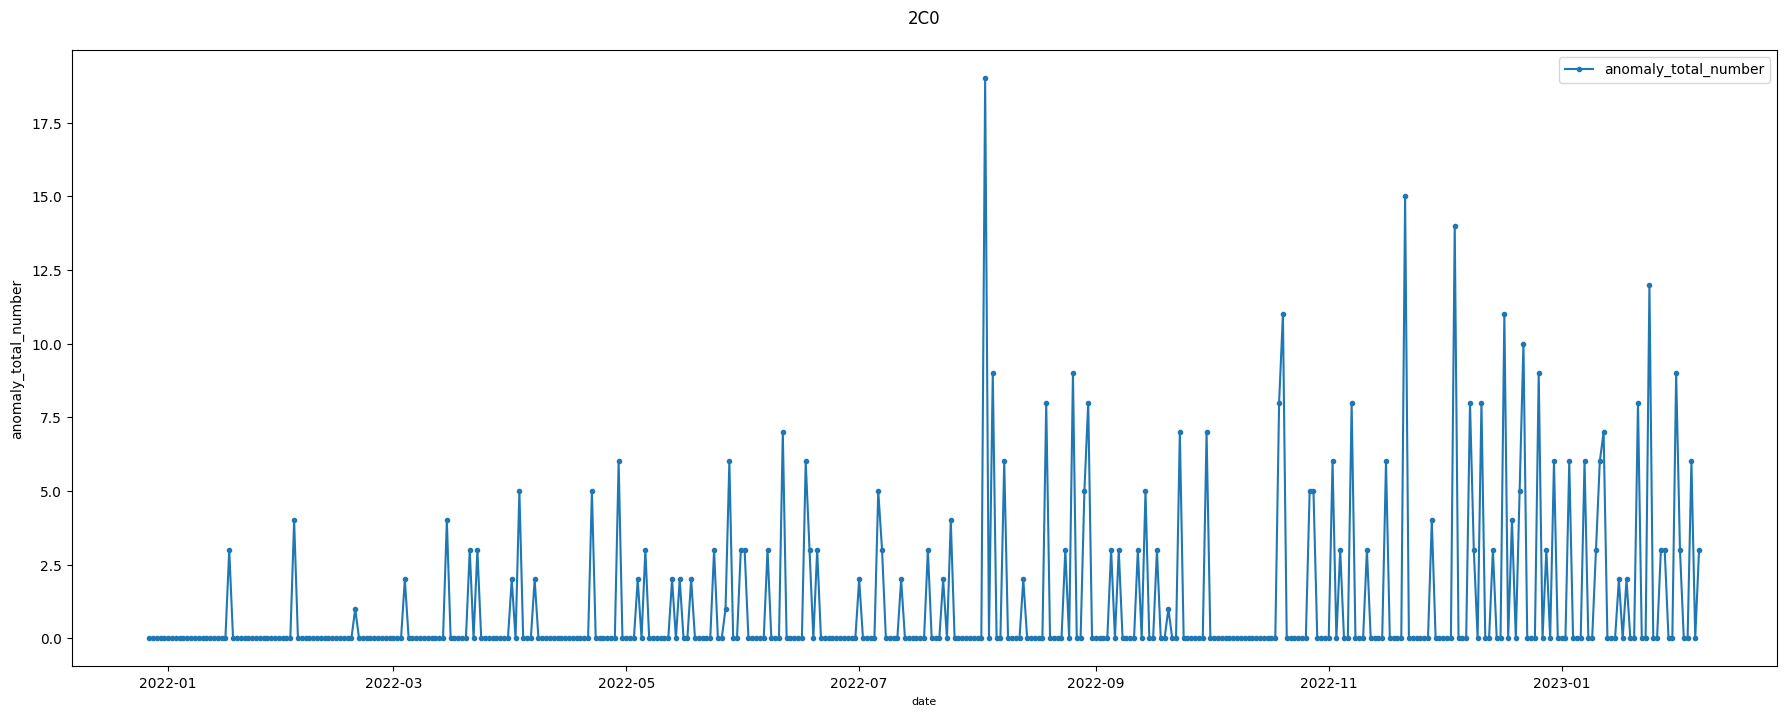

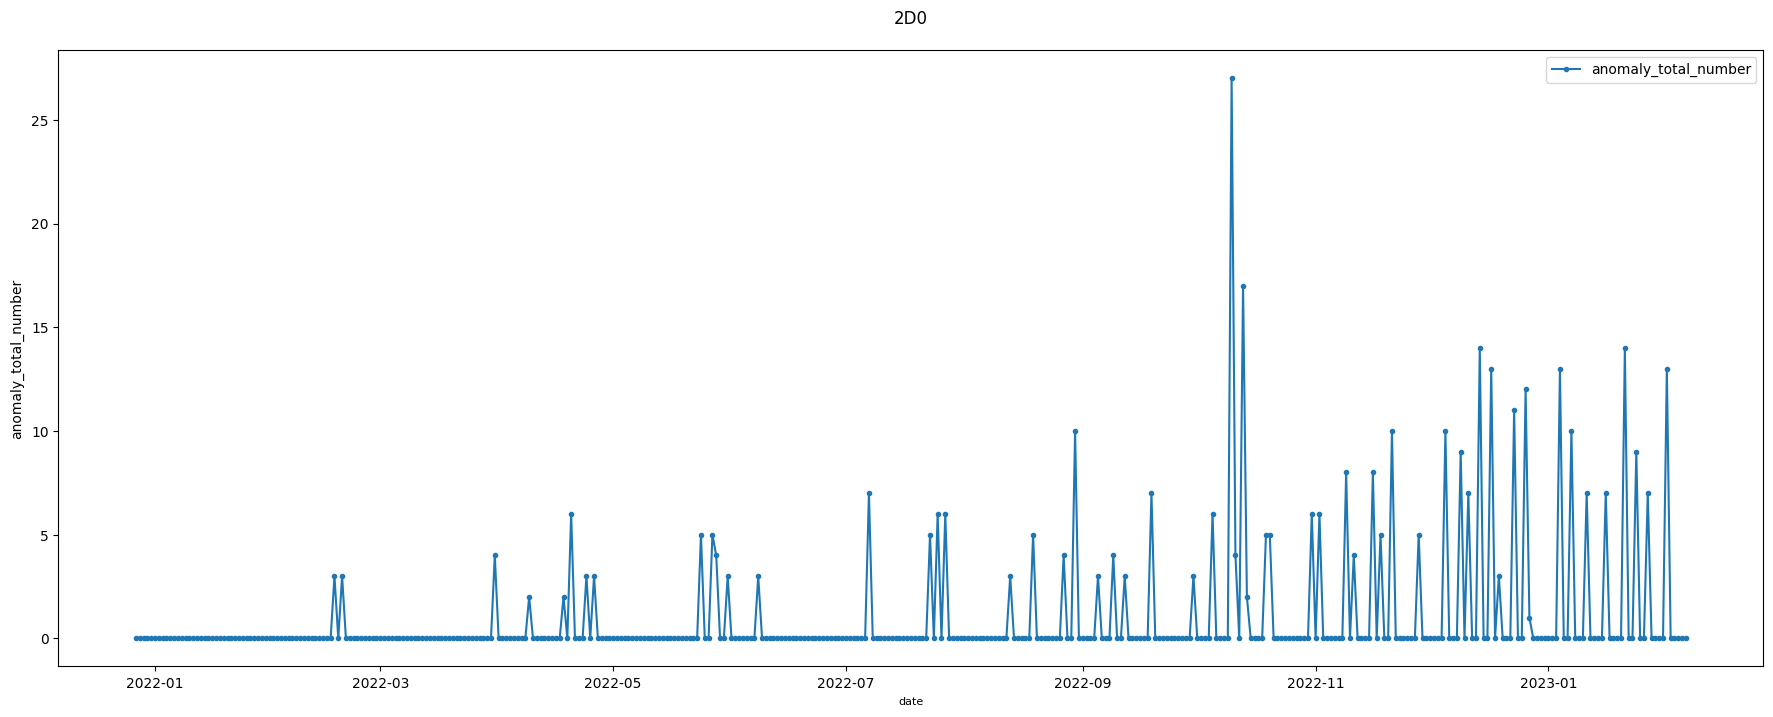

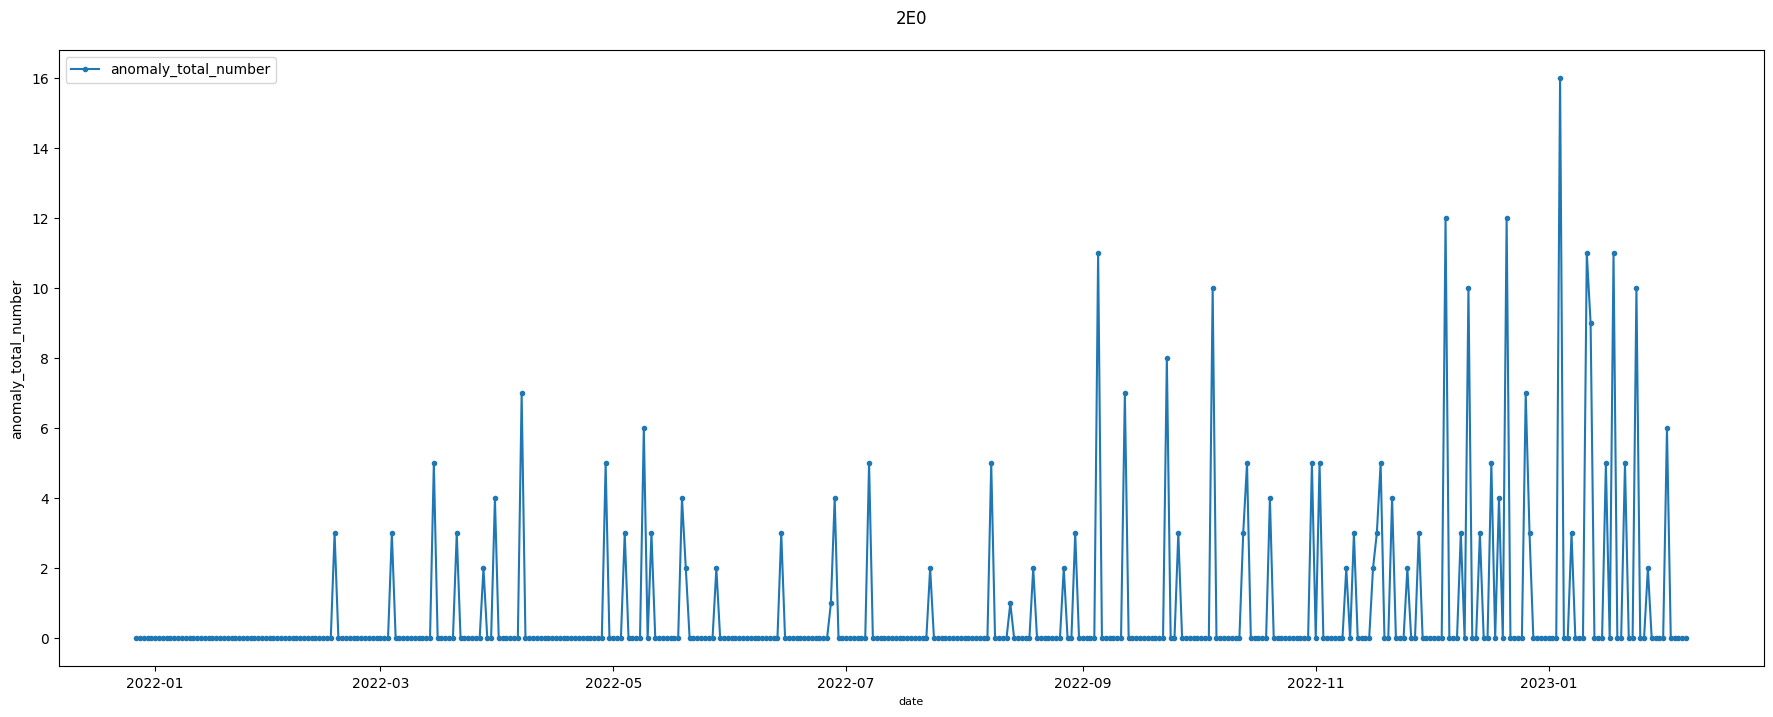

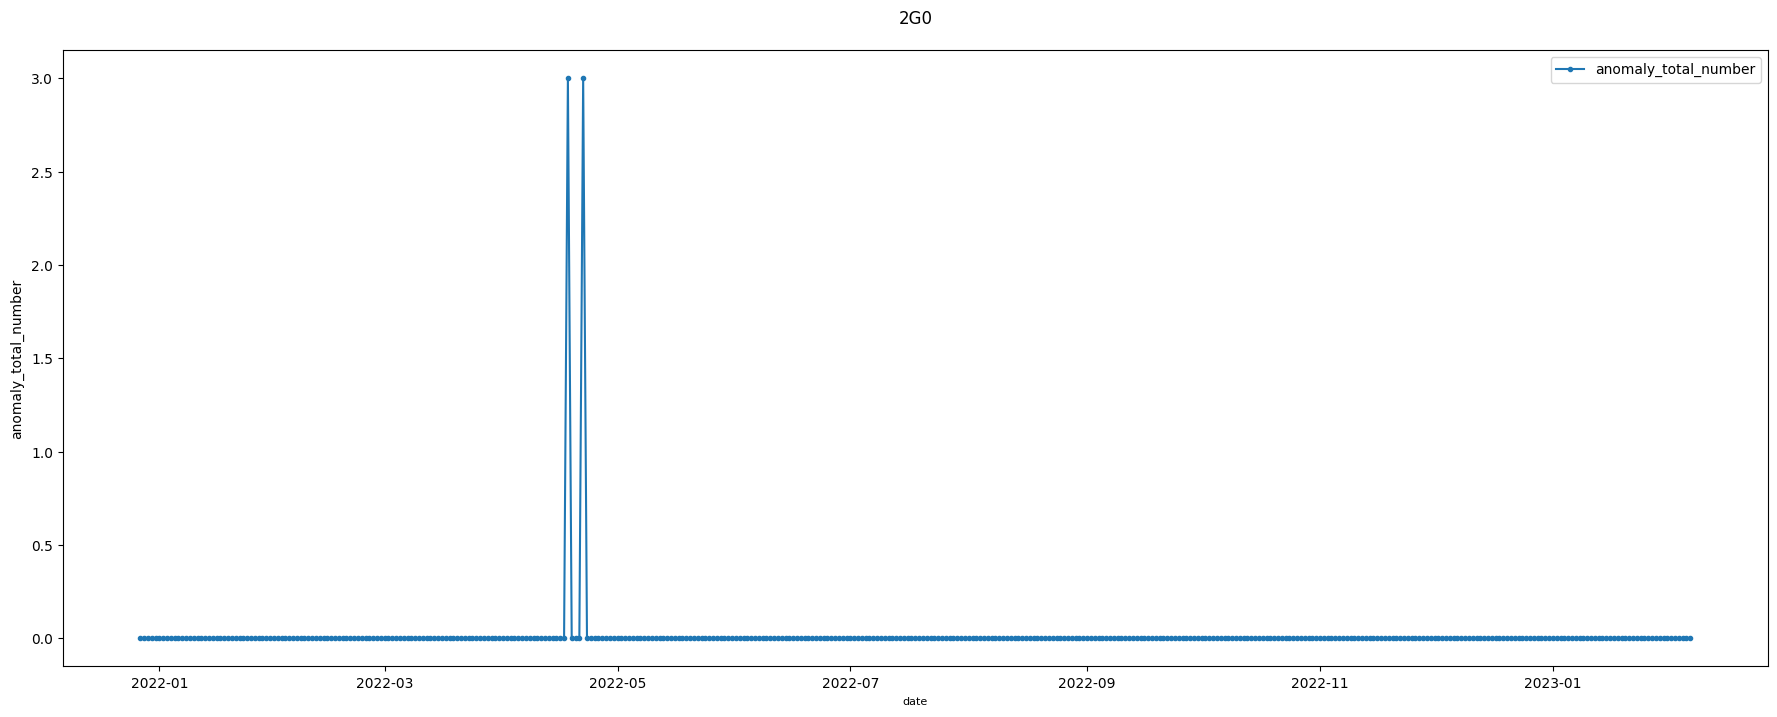

In [ ]:
def plot():
    oven_2 = ['2B0','2C0','2D0','2E0','2G0']
    for i in oven_2:
        oven_df = df[df['oven_id']==i].sort_values(by='date',ascending=True)
        oven2_total_anormal = oven_df.groupby(['date'])['anomaly_total_number'].sum()
        x = oven_df['date'].unique()
        y = oven2_total_anormal.values

        plt.figure(figsize = (22,8), dpi = 100, linewidth = 2)
        plt.plot( x, y , 'p-', label= 'anomaly_total_number',marker='.')
        plt.title(i , x = 0.5, y = 1.03)
        plt.yticks(fontsize = 10)
        plt.xlabel("date", fontsize = 8, labelpad = 5)
        plt.ylabel("anomaly_total_number", fontsize = 10, labelpad = 5)
        plt.legend(loc = "best", fontsize = 10)
        plt.plot()
plot()